In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import os
import warnings
warnings.filterwarnings('ignore')

if os.path.isdir('/home/jovyan/esci345/'):
    os.environ["ARTS_DATA_PATH"] = "/share/share/ESCI345/"
    os.environ["ARTS_XML_ATMO"] = "/share/share/esci345/atmospheres/"
else:
    os.environ["ARTS_DATA_PATH"] = "/Users/wgblumbe/Code/rttools/arts_catalogs/arts-cat-data-snapshot-arts-2.5.8/"
    os.environ["ARTS_XML_ATMO"] = "/Users/wgblumbe/Code/rttools/ESCI345/atmospheres/"
    
import pint
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import re
import optical_depth

pplt.use_style("default")
pplt.rc["legend.facecolor"] = "white"

ureg = pint.UnitRegistry()

def tag2tex(tag):
    """Replace all numbers in a species tag with LaTeX subscripts."""
    return re.sub("([a-zA-Z]+)([0-9]+)", r"\1$_{\2}$", tag)

In [25]:
freq_bounds = (10 * pint.Unit("GHz"), 200 * pint.Unit("GHz"))
freq_bounds = (400 * pint.Unit("1/centimeter"), 3000 * pint.Unit("1/centimeter"))

absorbers = optical_depth.getInfraredAbsorbers()
#absorbers = optical_depth.getMicrowaveAbsorbers()

#atmosphere = pd.read_csv(os.environ["ARTS_XML_ATMO"] + 'midlatitude-winter.csv')
#print(atmosphere)
atmosphere = 'midlatitude-winter' #midlatitude-summer, midlatitude-winter, subarctic-summer, subarctic-winter
profiles, arts_gas_ods, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, atmosphere=atmosphere, abs_species=absorbers)
optical_depths = arts_gas_ods['optical_depth']

## Plot Gas Optical Depths and Total Atmospheric Optical Depths

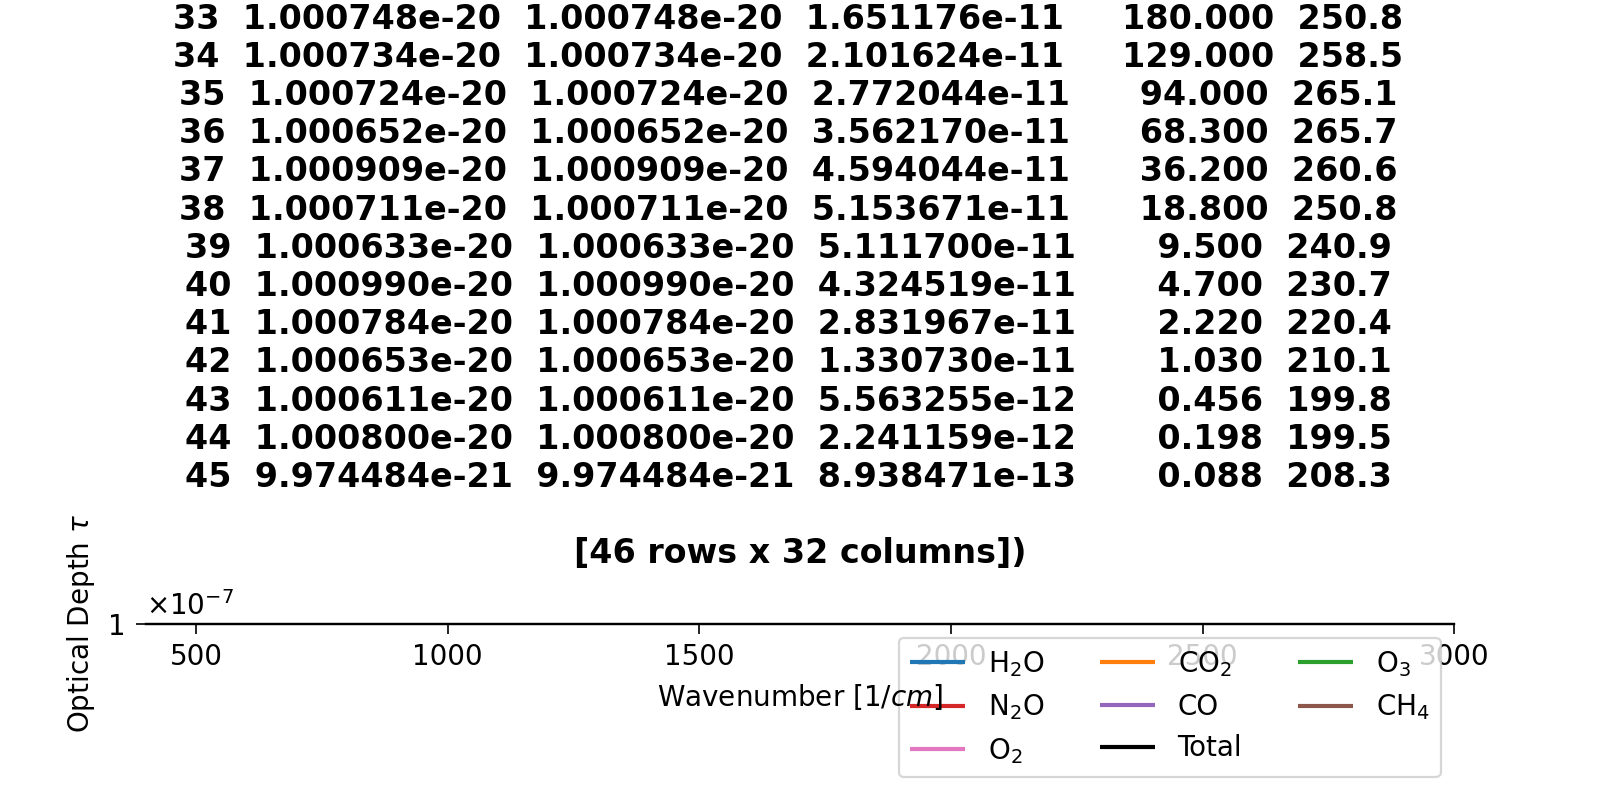

In [24]:
total_optical_depth = optical_depth.getTotalGasOpticalDepth(optical_depths)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(8,4))
for var in total_optical_depth:
    ax.plot(freq, var.values, label=tag2tex(str(var.gas_species.values)))
ax.format(xlim=freq_bounds, xlabel=optical_depth.get_spectral_unit(freq), ylabel=r"Optical Depth $\tau$",
          yscale='log', suptitle=f"Total Gas Optical Depth ({atmosphere})")
plt.plot(freq, total_optical_depth.sum(axis=0), c='k', label='Total')
plt.legend(loc=0)
plt.grid()
fig.savefig("optical_depth_example.pdf")
plt.show()

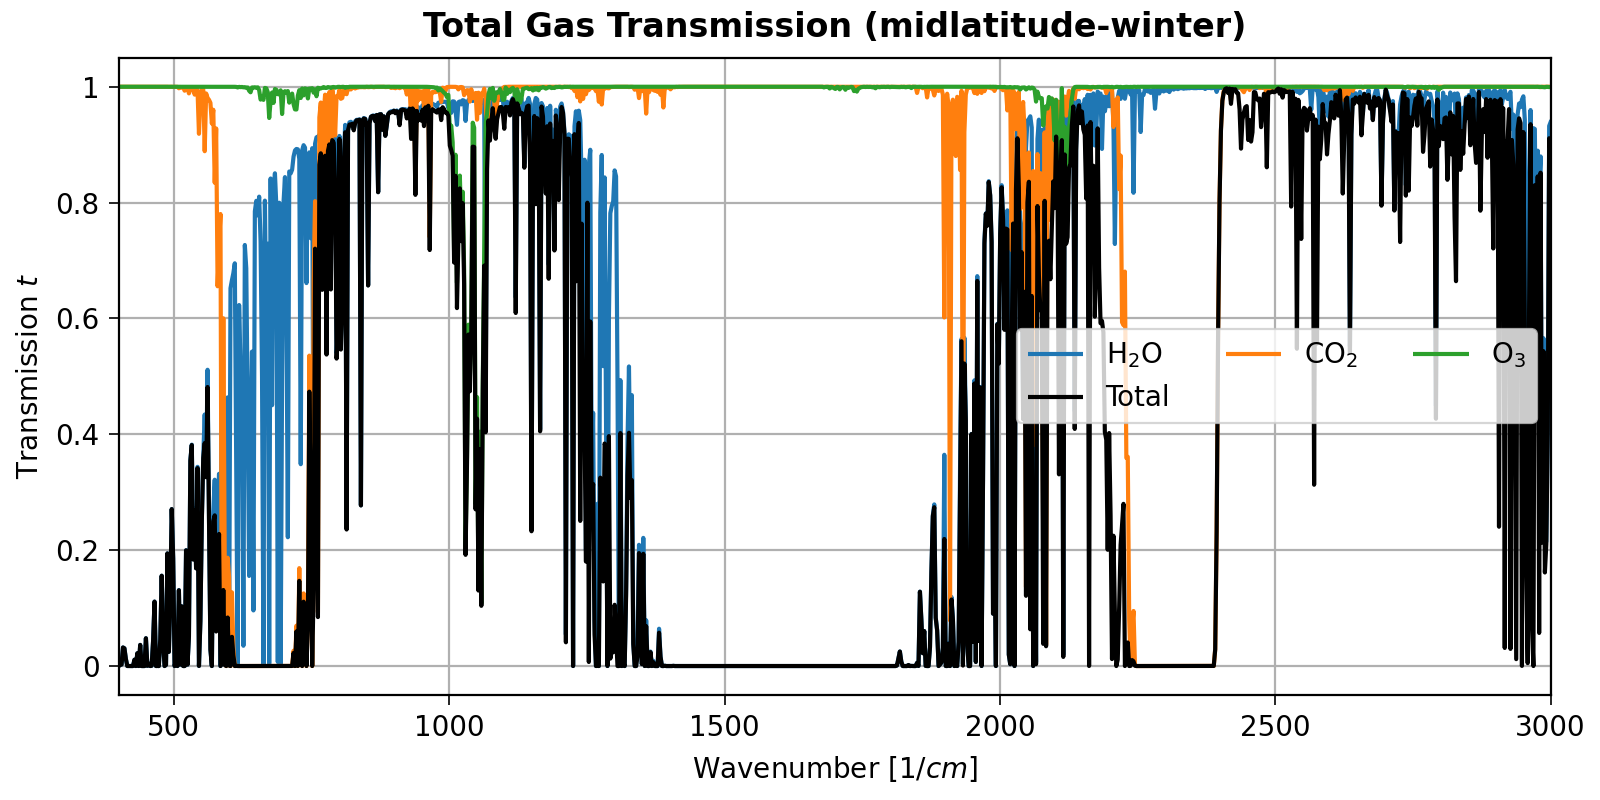

In [6]:
total_gas_transmission = optical_depth.getTotalGasTransmission(optical_depths)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(8,4))
for var in total_gas_transmission[:3]:
    ax.plot(freq, var.values, label=tag2tex(str(var.gas_species.values)))
ax.format(xlim=freq_bounds, xlabel=optical_depth.get_spectral_unit(freq), ylabel="Transmission $t$",
         suptitle=f"Total Gas Transmission ({atmosphere})")
plt.plot(freq, total_gas_transmission.prod(axis=0), c='k', label='Total')
plt.legend(loc=0)
plt.grid()
fig.savefig("optical_depth_example.pdf")
plt.show()

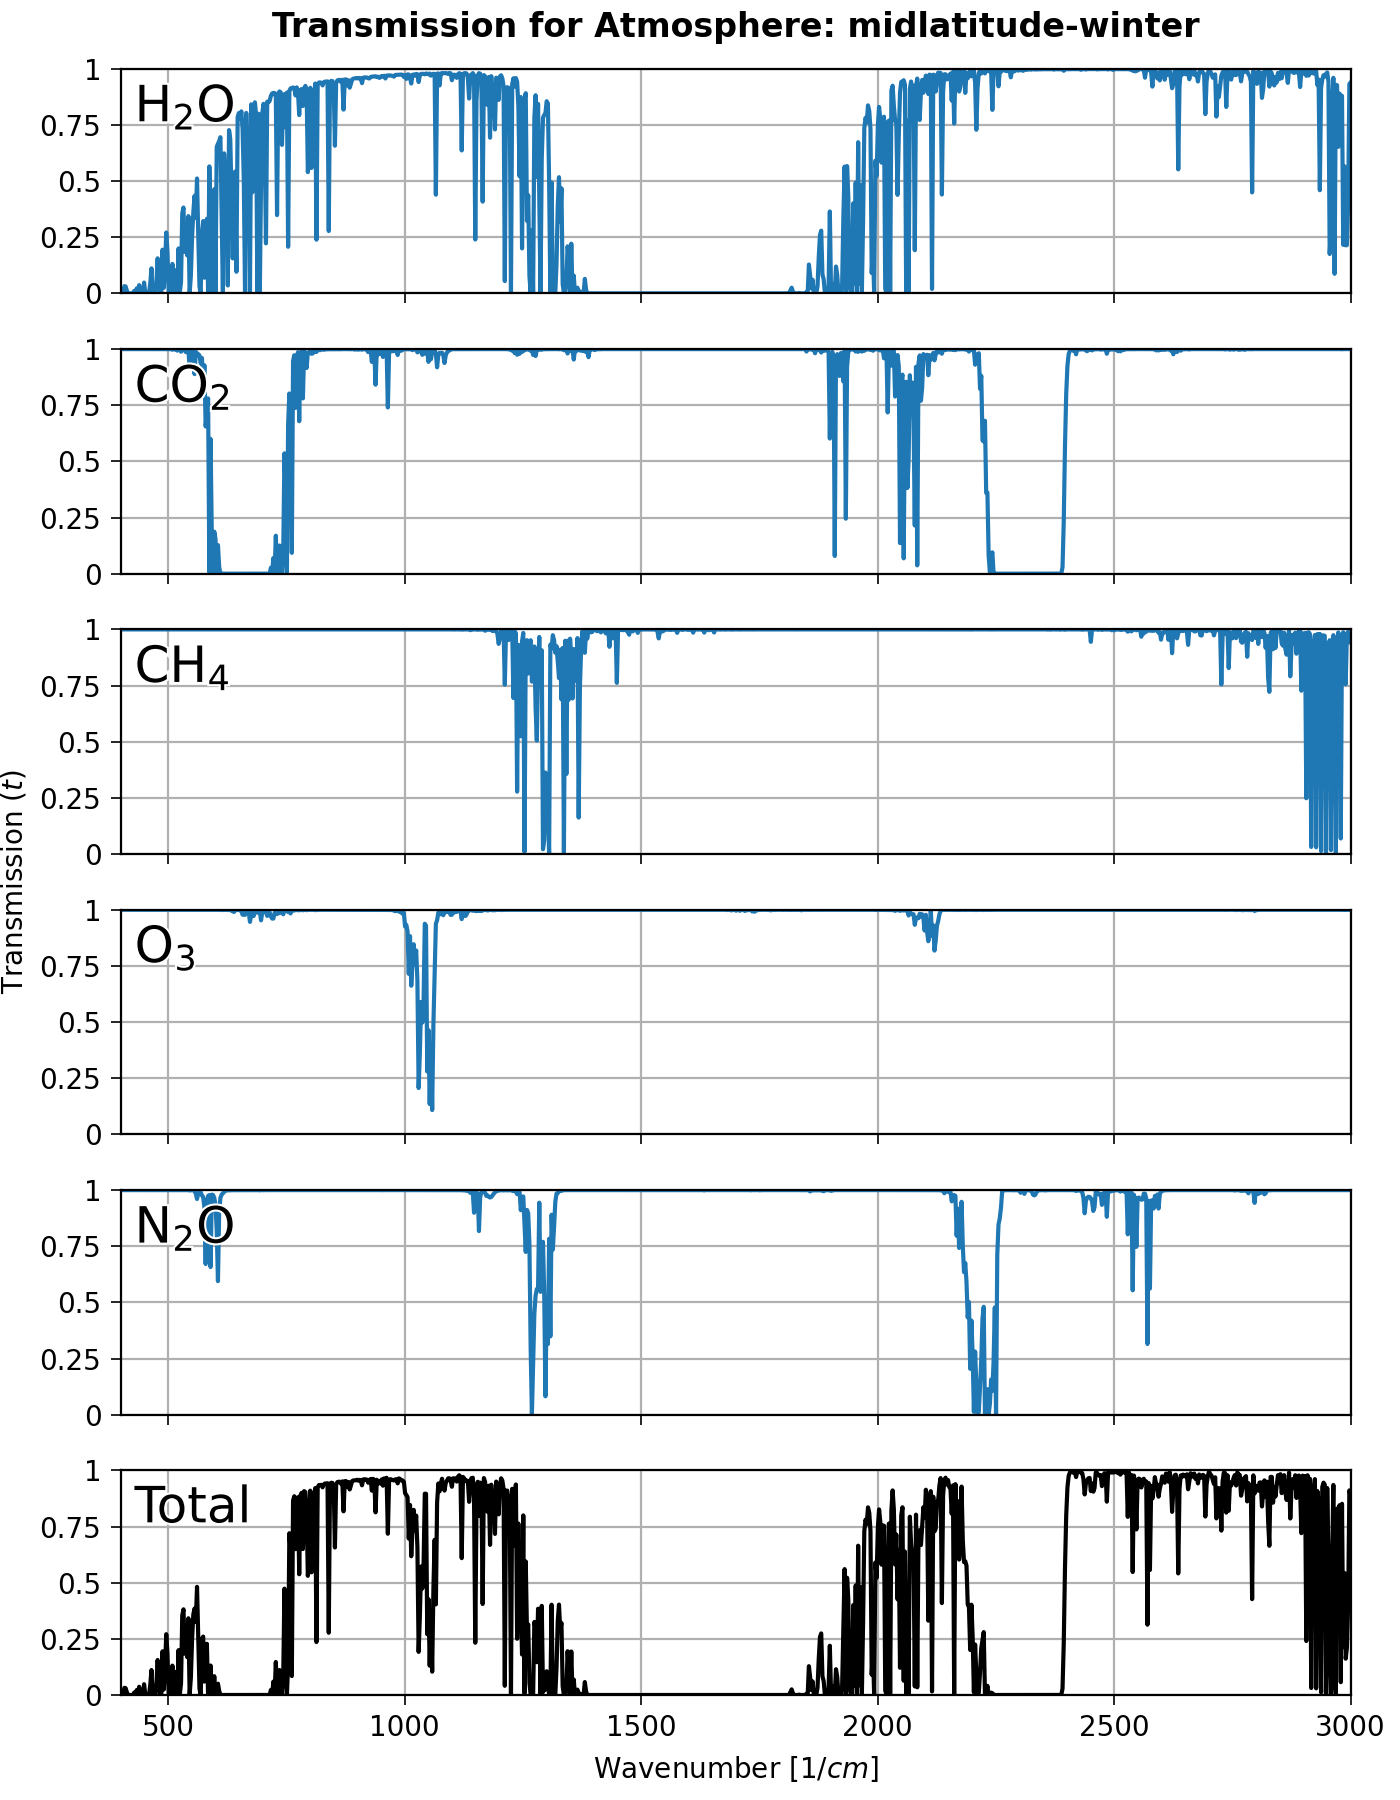

In [8]:
gas = ['H2O','CO2','CH4',"O3","N2O"]
#gas = ['H2O','O2',"N2","O3"]

fig, ax = pplt.subplots(nrows=len(gas)+1, ncols=1, figsize=(7,9), sharex=True, sharey=True)
fig.format(xlabel=optical_depth.get_spectral_unit(freq),ylabel='Transmission ($t$)', grid=True, 
           ylim=(0,1), suptitle=f"Transmission for Atmosphere: {atmosphere}")
for i, gas_name in enumerate(gas):
    ax[i].format(ultitle=f"{tag2tex(gas_name)}", titlesize=18)
    ax[i].plot(freq, total_gas_transmission.sel(gas_species=gas_name))

ax[-1].plot(freq, total_gas_transmission.prod(axis=0), c='k')
ax[-1].format(ultitle=f"Total", titlesize=18)

pplt.show()

## Spectral Transmission and Zenith Angle

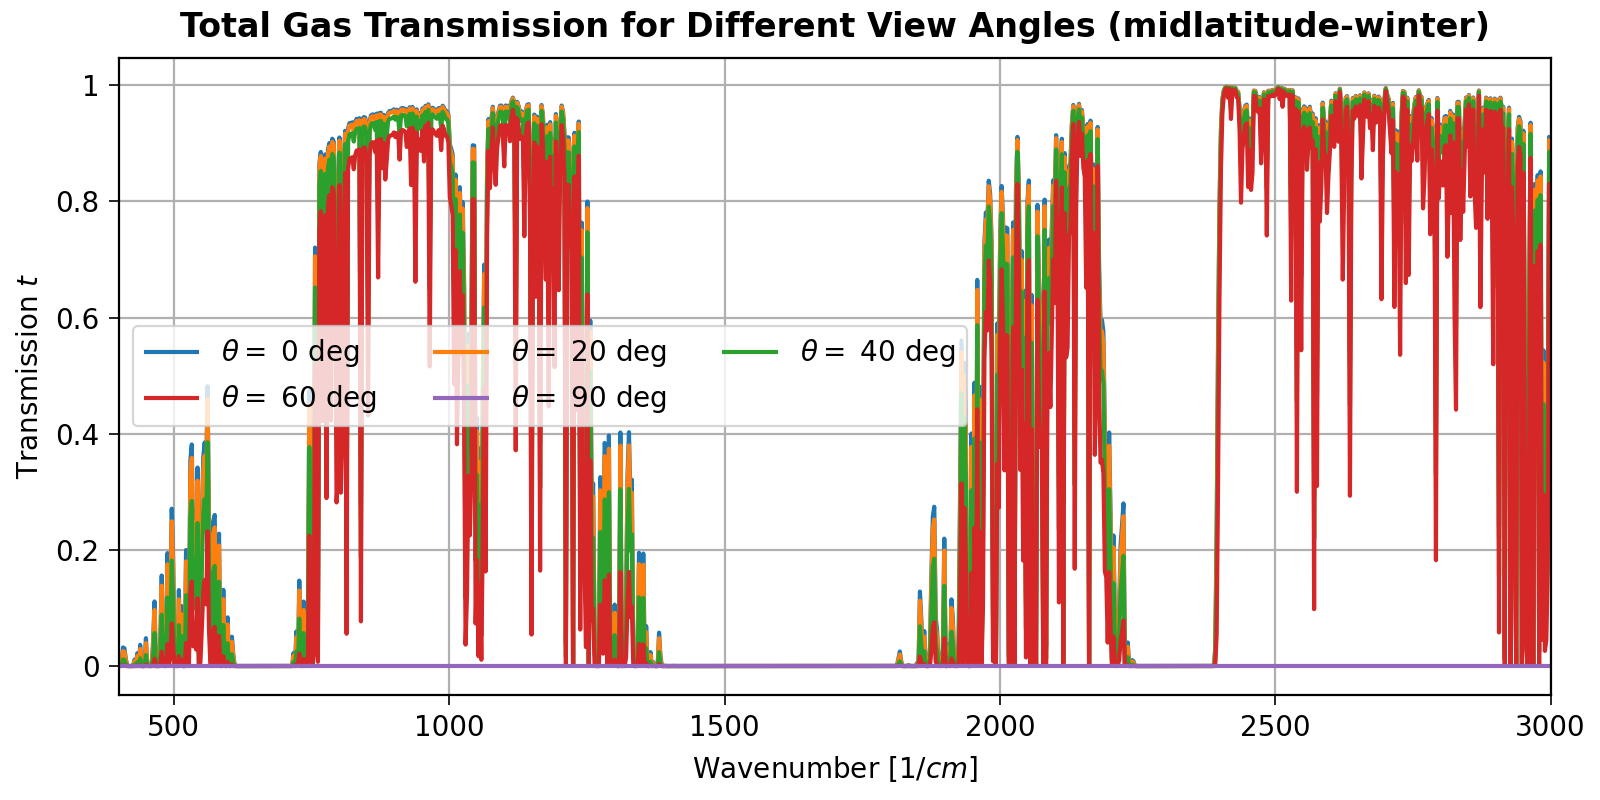

In [9]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.format(xlim=freq_bounds, xlabel=optical_depth.get_spectral_unit(freq), ylabel="Transmission $t$",
          suptitle=f"Total Gas Transmission for Different View Angles ({atmosphere})")

for zenith in [0,20,40,60,90]:
    mu = np.abs(np.cos(np.radians(zenith)))
    total_transmission = np.exp(-total_optical_depth.sum(axis=0)/mu)
    ax.plot(freq, total_transmission, label=rf'$\theta = $ {zenith} deg')
ax.legend(loc=0)
ax.grid()
fig.savefig("optical_depth_example.pdf")
plt.show()

## Atmospheric Optical Depth Structure

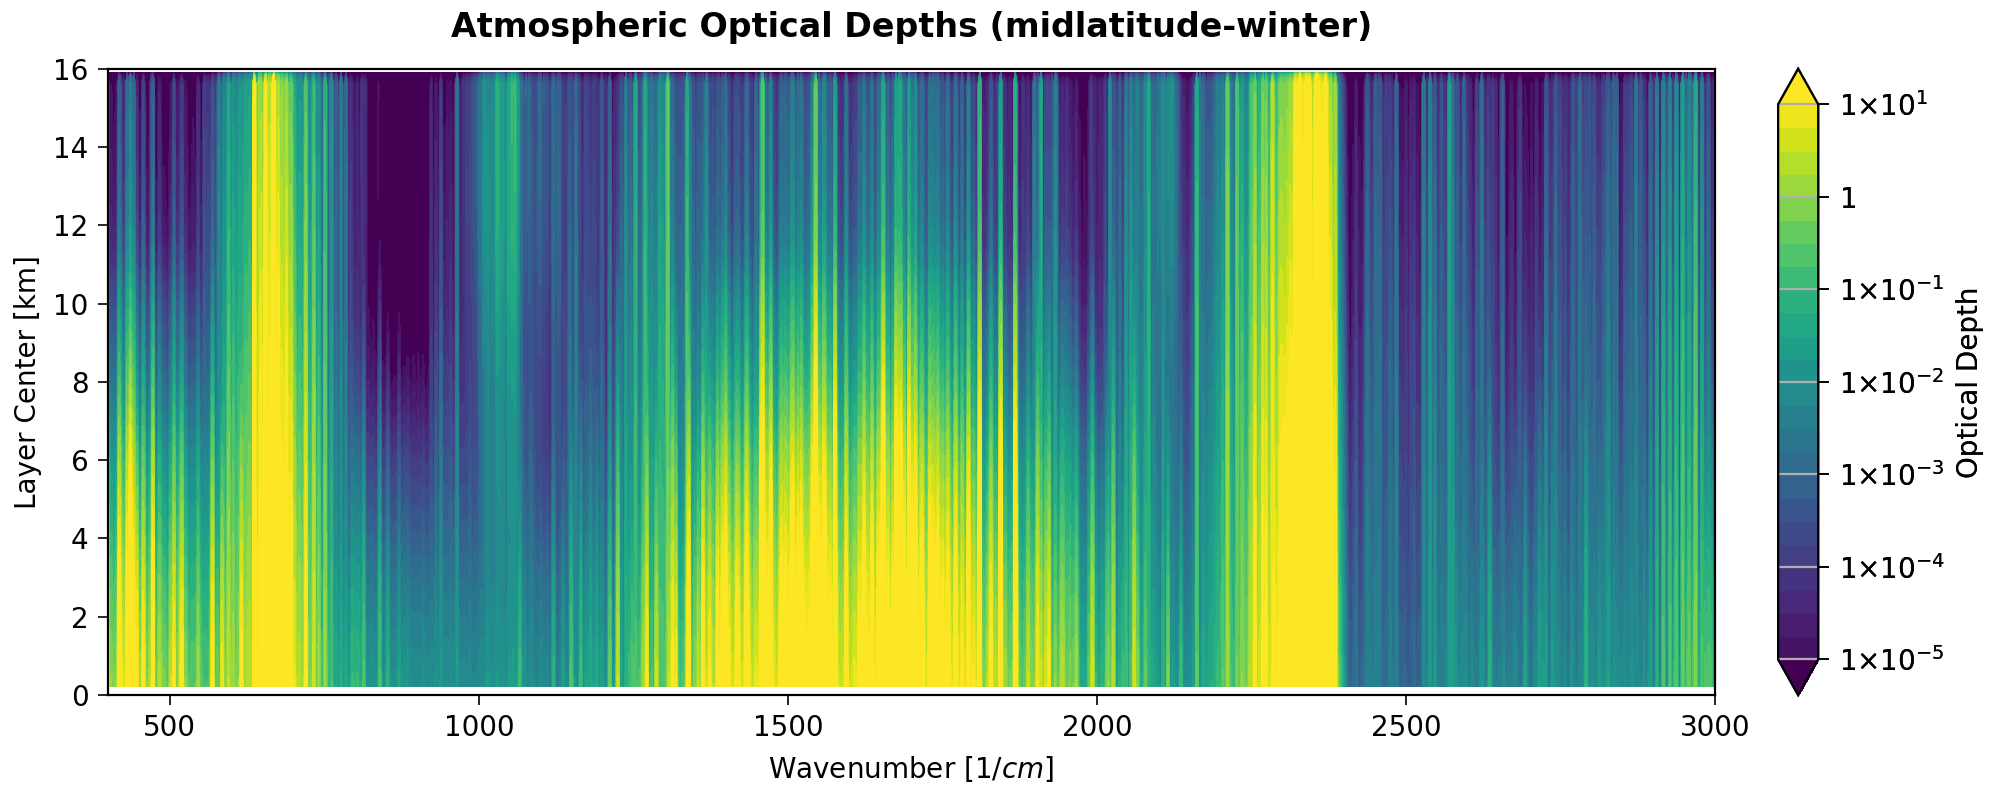

In [10]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(10,4))
fig.format(suptitle=f"Atmospheric Optical Depths ({atmosphere})")
c = ax.contourf(freq, optical_depths.layer_center.pint.to("kilometer"), np.sum(optical_depths, axis=0).T, vmin=1e-5, vmax=1e1, norm='log', levels=30, extend='both')
ax.format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
fig.colorbar(c, formatter='sci', label="Optical Depth", ticks=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
plt.grid()
fig.save("plots/atmospheric_optical_depth.pdf")
plt.show()

## Layer to Instrument Optical Depths

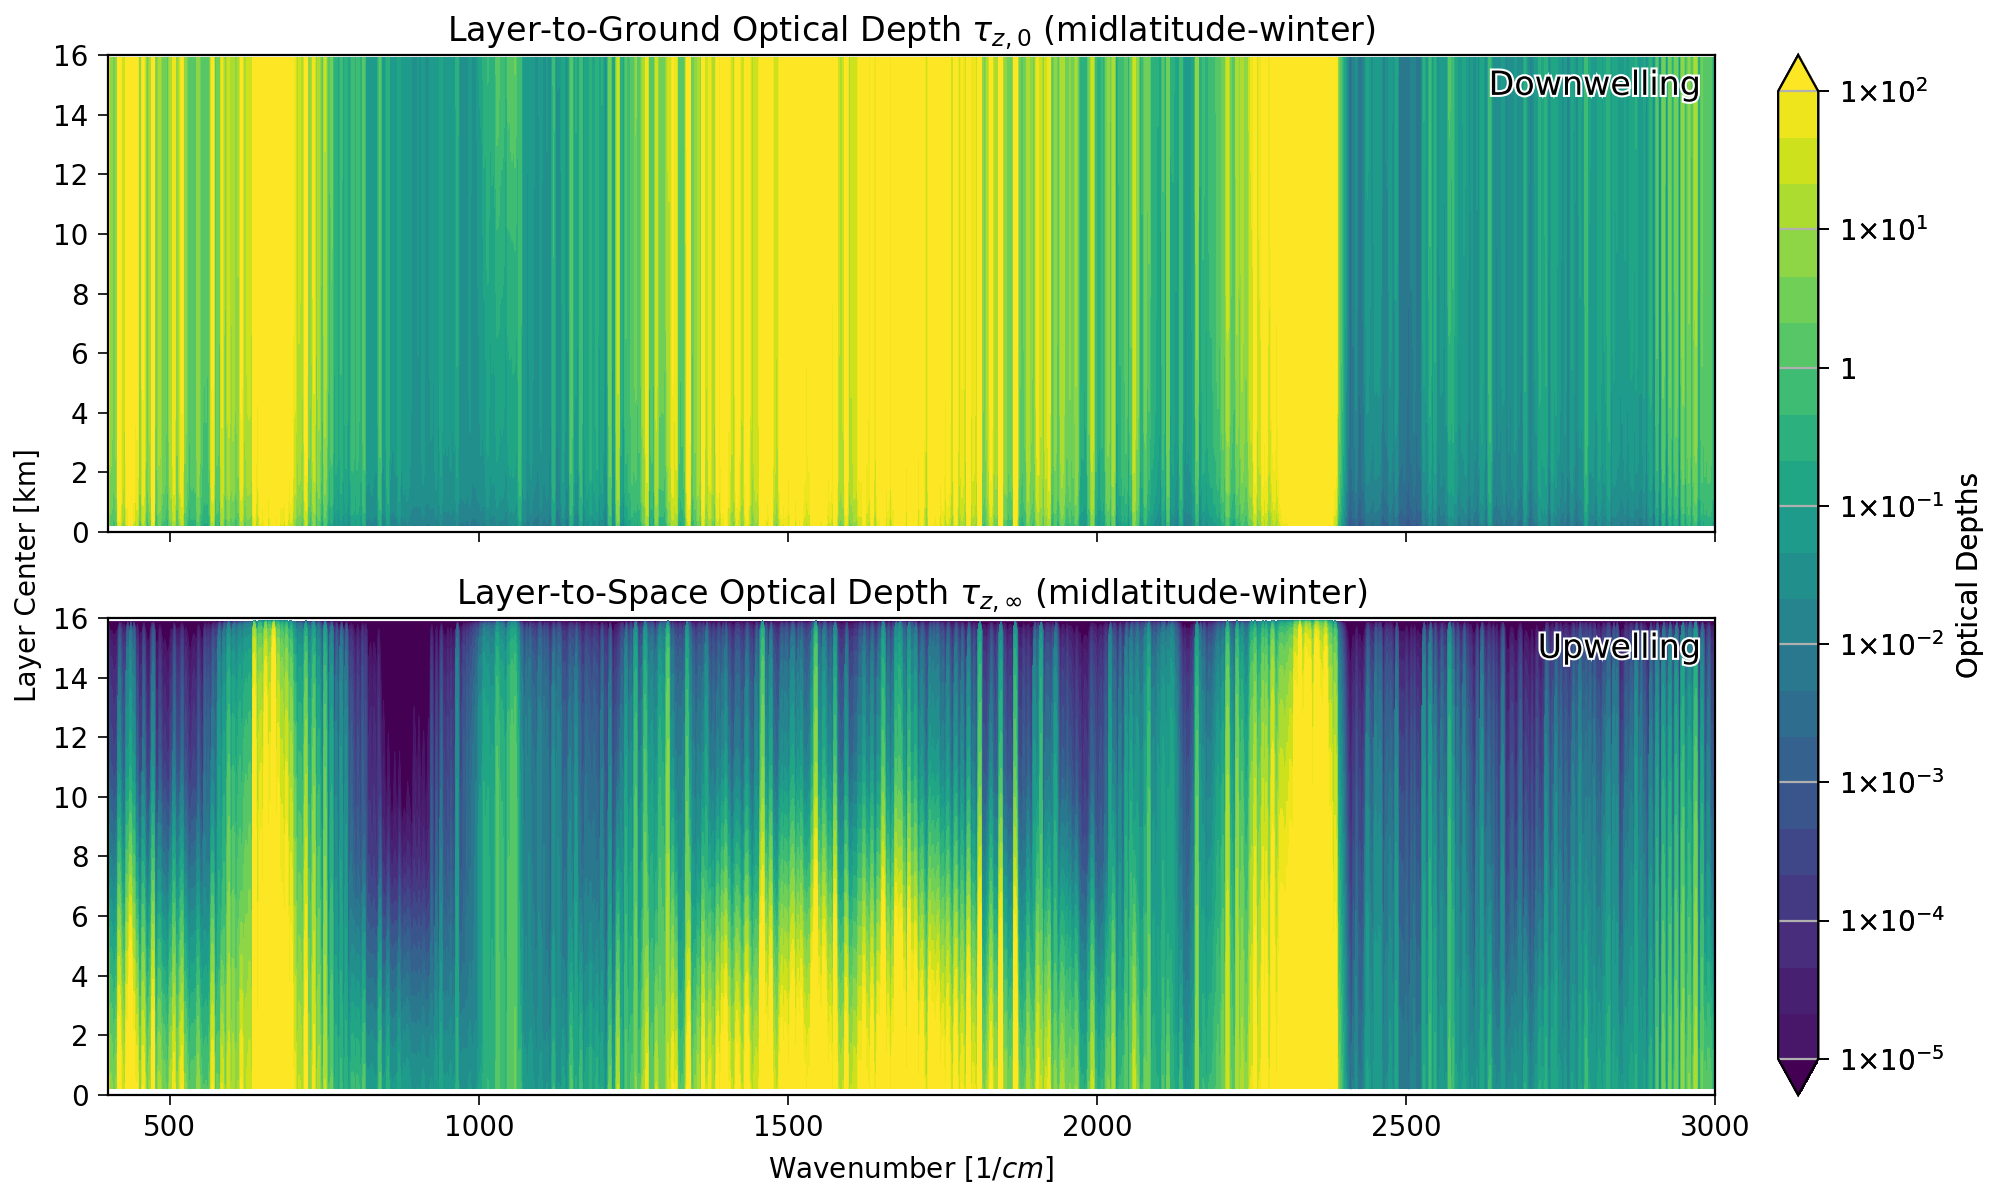

In [11]:
all_ods = np.sum(optical_depths, axis=0).T # sum optical depths over all gases

upwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)
downwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)

for hght_idx in np.arange(upwelling_ods.shape[0]):
    downwelling_ods[hght_idx,:] = np.sum(all_ods[:hght_idx+1,:], axis=0)
    upwelling_ods[hght_idx,:] = np.sum(all_ods[hght_idx:,:], axis=0)

avg_h = optical_depths.layer_center.pint.to("kilometer")

fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(10,6))
ax[0].format(title=rf"Layer-to-Ground Optical Depth $\tau_{{z,0}}$ ({atmosphere})", urtitle="Downwelling")
c = ax[0].contourf(freq, avg_h, downwelling_ods, vmin=1e-5, vmax=1e2, norm='log', levels=30, extend='both')
ax[0].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
fig.colorbar(c, formatter='sci', label="Optical Depths", ticks=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2])

ax[1].format(title=rf"Layer-to-Space Optical Depth $\tau_{{z,\infty}}$ ({atmosphere})", urtitle="Upwelling")
c = ax[1].contourf(freq, avg_h, upwelling_ods, vmin=1e-5, vmax=1e2, norm='log', levels=30, extend='both')
ax[1].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
plt.grid()
fig.save("plots/lyr2inst_od.pdf")
plt.show()

## Layer to Instrument Transmission (with view angle)

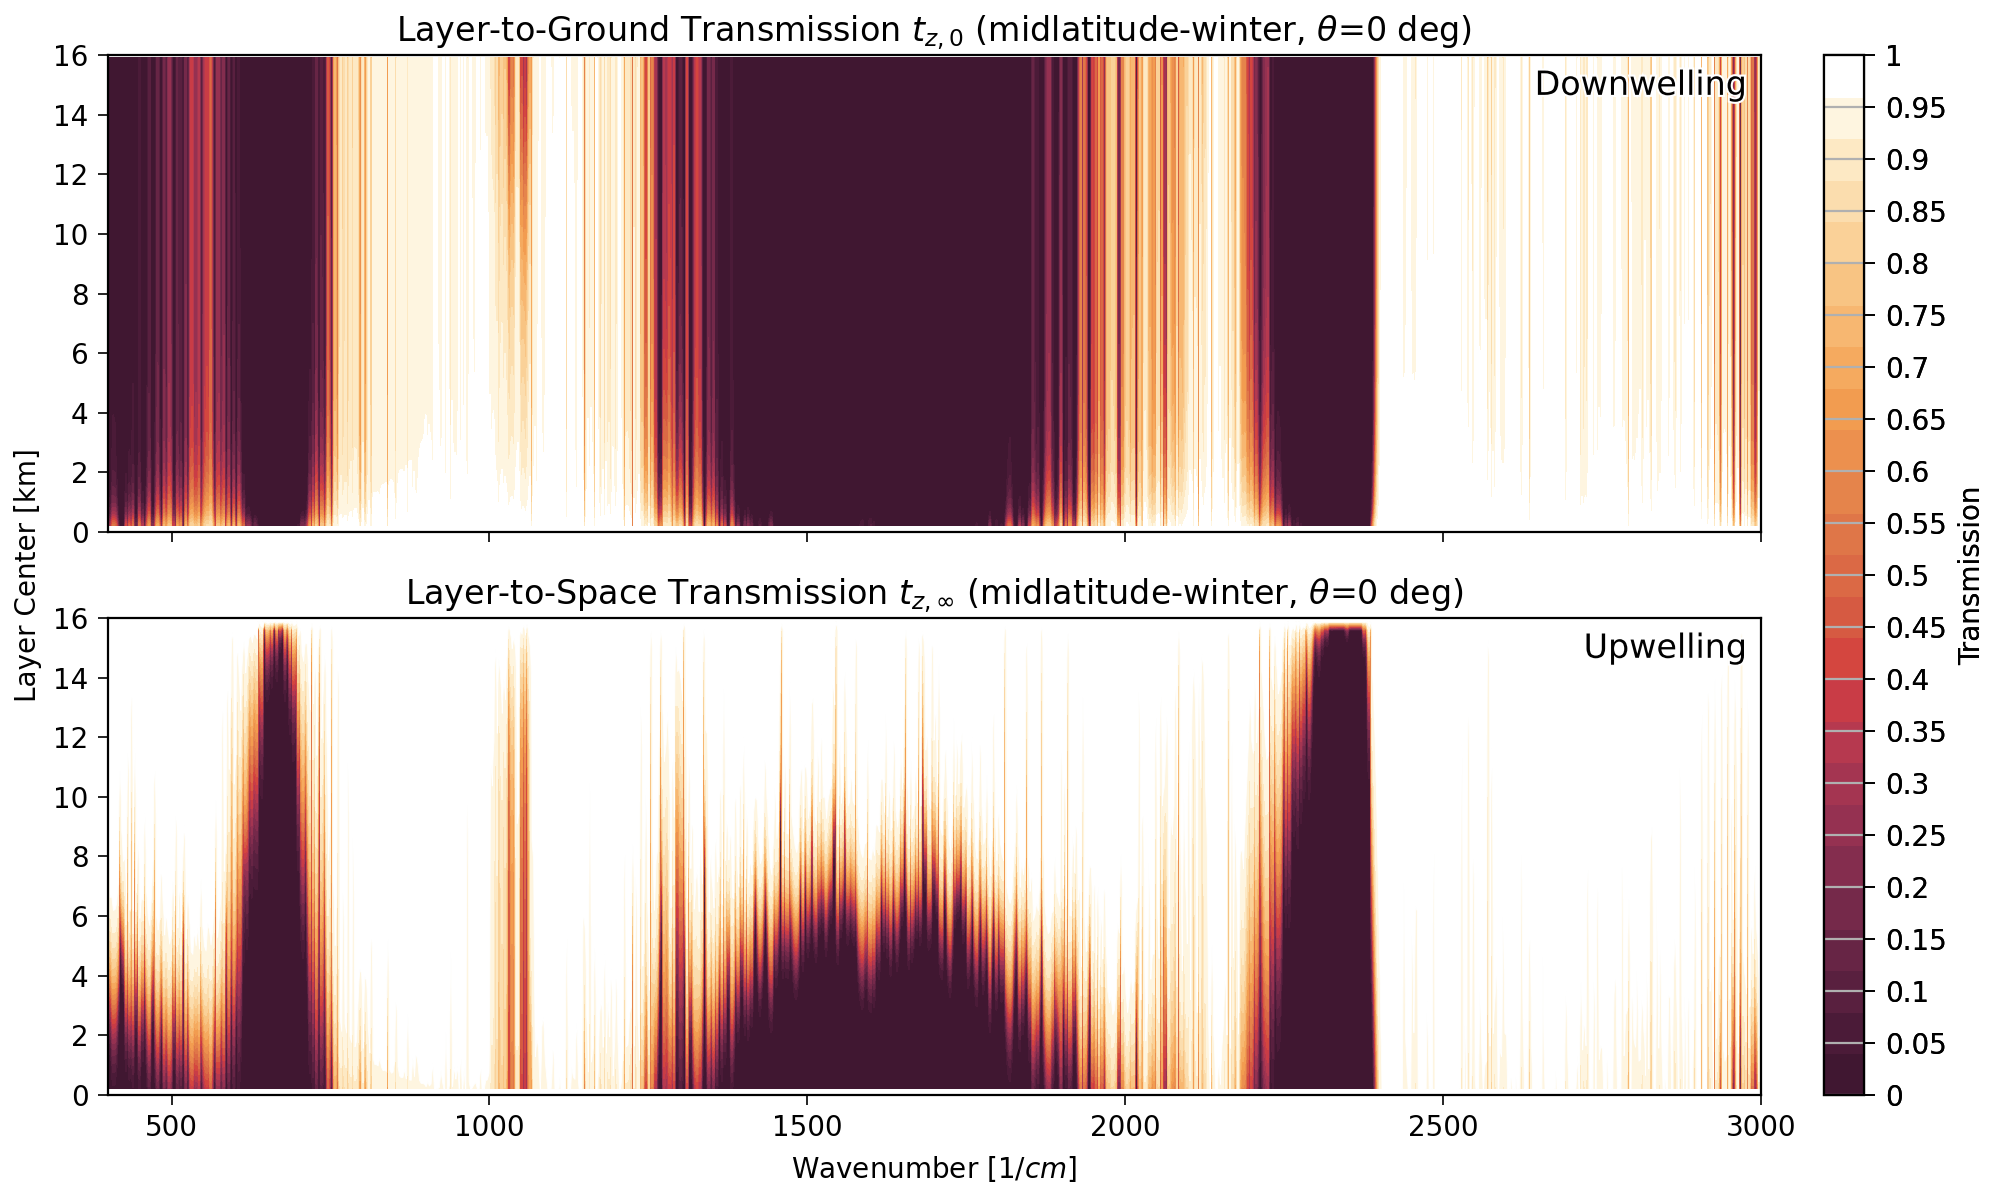

In [12]:
zenith = 0
mu = np.abs(np.cos(np.radians(zenith)))

all_ods = np.sum(optical_depths, axis=0).T

upwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)
downwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)

for hght_idx in np.arange(upwelling_ods.shape[0]):
    downwelling_ods[hght_idx,:] = np.sum(all_ods[:hght_idx+1,:], axis=0)
    upwelling_ods[hght_idx,:] = np.sum(all_ods[hght_idx:,:], axis=0)

fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(10,6))
ax[0].format(title=rf"Layer-to-Ground Transmission $t_{{z,0}}$ ({atmosphere}, $\theta$={zenith} deg)", urtitle="Downwelling")
c = ax[0].contourf(freq, avg_h, np.exp(-downwelling_ods/mu), vmin=0, vmax=1, levels=30, cmap='Fire_r')
ax[0].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
fig.colorbar(c, label="Transmission", ticks=np.arange(0,1.05,.05))

ax[1].format(title=rf"Layer-to-Space Transmission $t_{{z,\infty}}$ ({atmosphere}, $\theta$={zenith} deg)", urtitle="Upwelling")
c = ax[1].contourf(freq, avg_h, np.exp(-upwelling_ods/mu), vmin=0, vmax=1, levels=30, cmap='Fire_r')
ax[1].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
plt.grid()
fig.save("plots/lyr2inst_trans.pdf")
plt.show()

## Instrument Weighting Functions (with view angle)

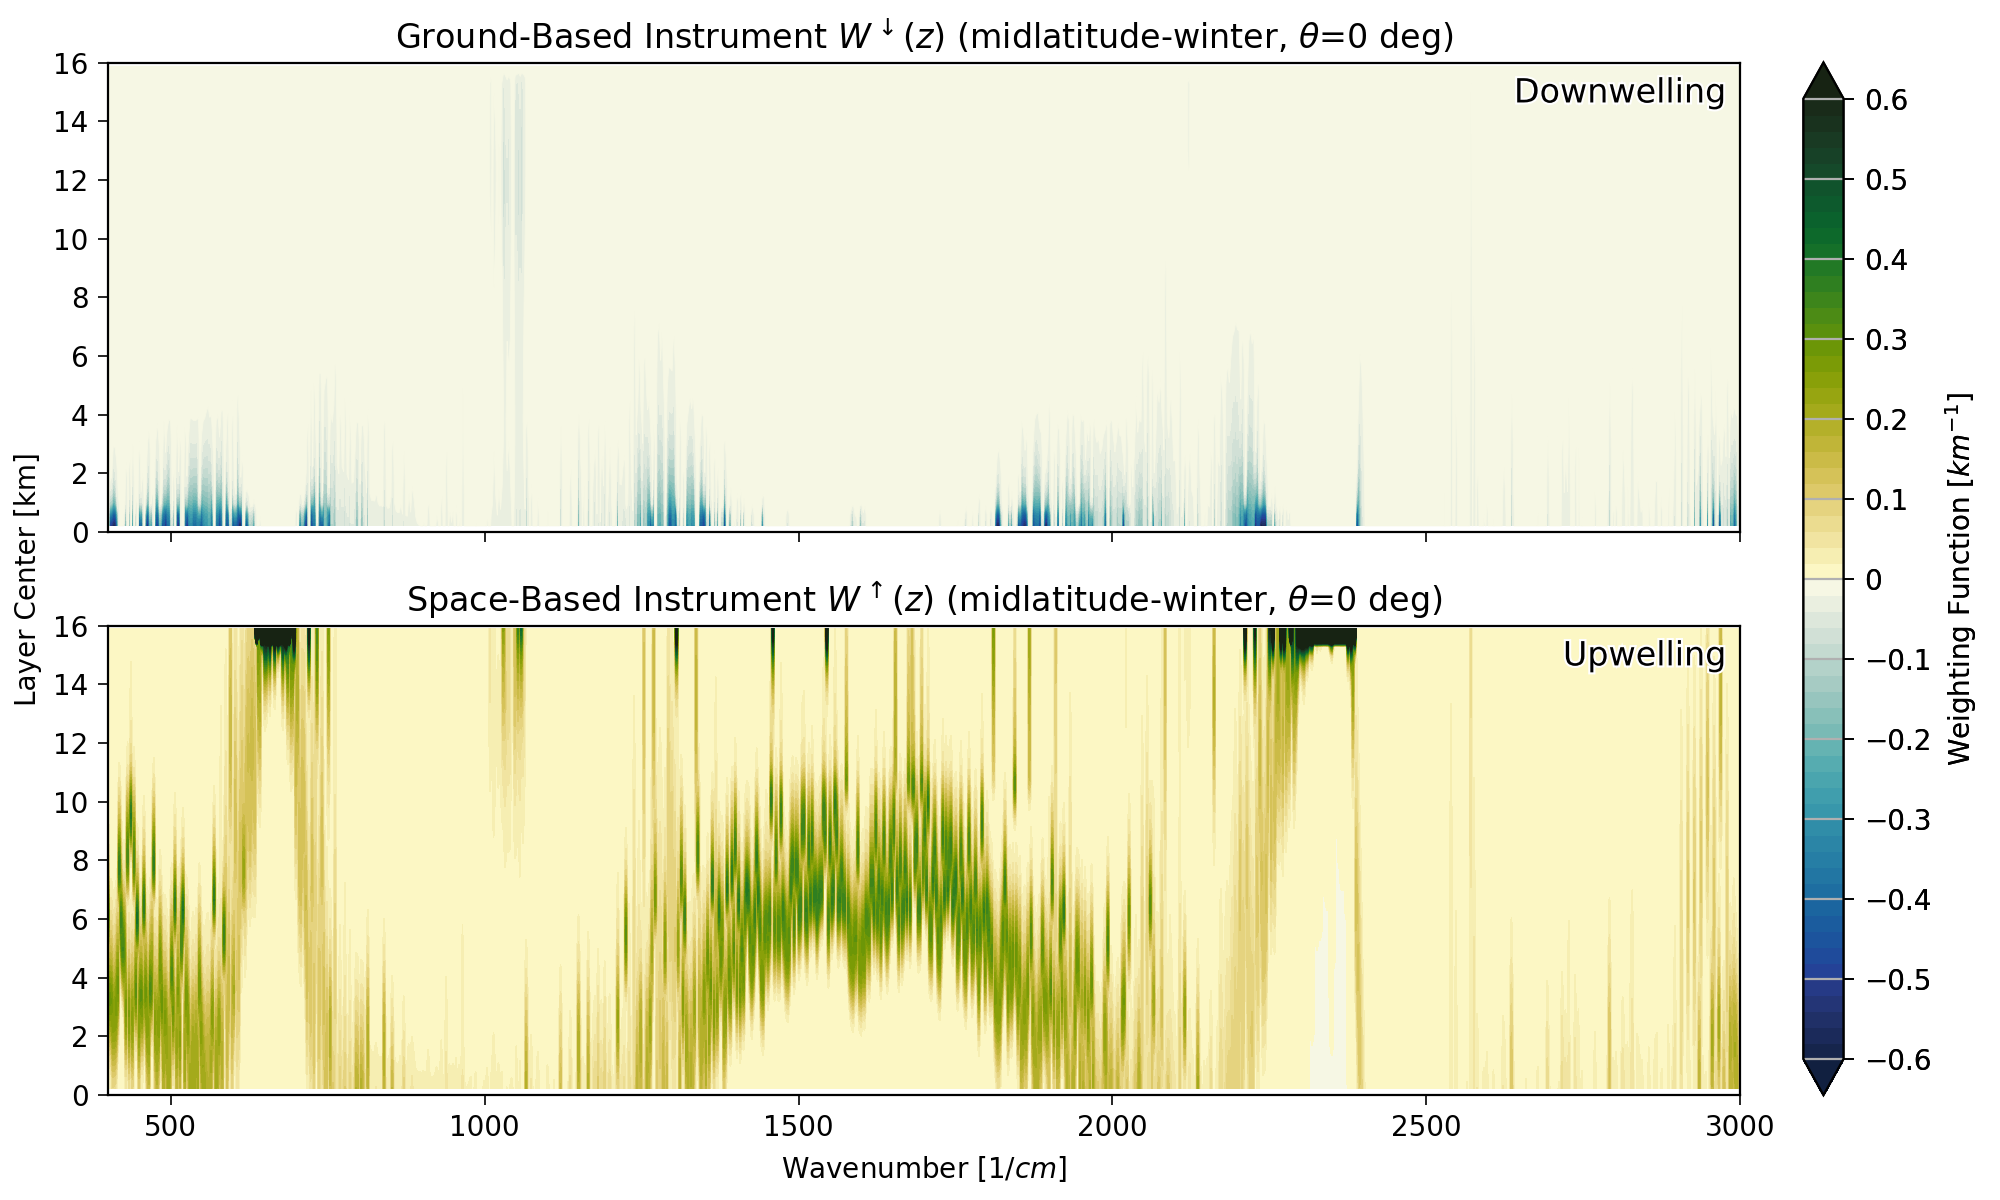

In [14]:
zenith = 0
mu = np.abs(np.cos(np.radians(zenith)))

all_ods = np.sum(optical_depths, axis=0).T

upwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)
downwelling_ods = np.zeros(np.sum(optical_depths, axis=0).T.shape)

for hght_idx in np.arange(upwelling_ods.shape[0]):
    downwelling_ods[hght_idx,:] = np.sum(all_ods[:hght_idx+1,:], axis=0)
    upwelling_ods[hght_idx,:] = np.sum(all_ods[hght_idx:,:], axis=0)

upwelling_w = np.gradient(np.exp(-upwelling_ods/mu), avg_h, axis=0)
downwelling_w = np.gradient(np.exp(-downwelling_ods/mu), avg_h, axis=0)

fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(10,6))
ax[0].format(title=rf"Ground-Based Instrument $W^\downarrow(z)$ ({atmosphere}, $\theta$={zenith} deg)", urtitle="Downwelling")
c = ax[0].contourf(freq, avg_h, downwelling_w, vmin=-.6, vmax=.6, levels=60, cmap="Delta", extend='both')
ax[0].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))

ax[1].format(title=rf"Space-Based Instrument $W^\uparrow(z)$ ({atmosphere}, $\theta$={zenith} deg)", urtitle="Upwelling")
c = ax[1].contourf(freq, avg_h, upwelling_w, levels=60, vmin=-.6, vmax=.6, cmap="Delta", extend='both')
ax[1].format(ylim=(0,16), yticks=np.arange(0,20,2), ylabel="Layer Center [km]", xlabel=optical_depth.get_spectral_unit(freq))
fig.colorbar(c, label="Weighting Function [$km^{-1}$]", ticks=np.arange(-.6,.7,.1))
plt.grid()
fig.save("plots/inst_wf.pdf")
plt.show()

## Species Mass Path

$u_{s} = \int_0^{\infty} \rho_s dz$

Integrated Water Vapor: 0.847 cm


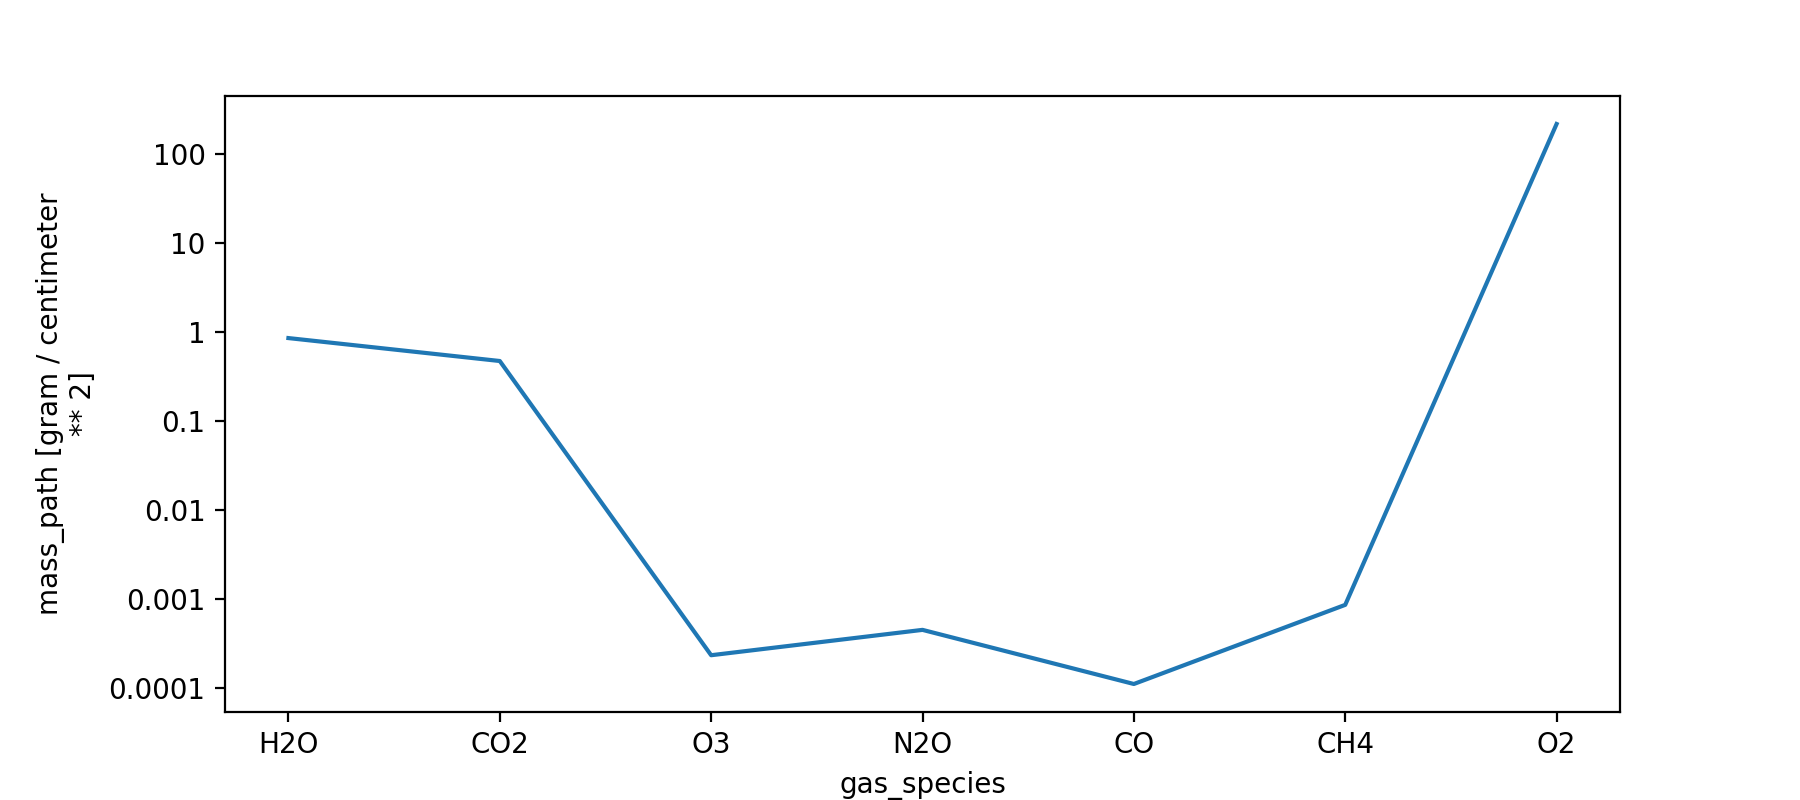

In [16]:
arts_gas_ods['mass_path'].plot(yscale='log', figsize=(9,4))

print(f"Integrated Water Vapor: {arts_gas_ods['mass_path'].to_pandas()['H2O']:.3f} cm")